Clinical Only

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

from sklearn.utils import resample
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap
from collections import defaultdict


In [2]:
#Added relative path, place path where data is in this line.
data = pd.read_csv("C:/Users/migue/OneDrive/Desktop/ML Project/Counts/Individual Files/Extracted/Invidual/ML_project_Clinical only.csv")
print(data)
#Need to work on this.
x_frame = data.iloc[: , :-1]
#x_frame = x_frame.to_numpy()

y_frame = data.iloc[:,-1:]


print(x_frame)
print(y_frame)

print(x_frame.shape)

print(y_frame.shape)

     Age at Index  Age of Diagnosis in Days  Days from Birth  \
0              46                     17037           -17037   
1              63                     23211           -23211   
2              56                     20555           -20555   
3              65                     24050           -24050   
4              60                     22029           -22029   
..            ...                       ...              ...   
158            31                     11333           -11333   
159            75                     27511           -27511   
160            50                     18571           -18571   
161            72                     26600           -26600   
162            54                     20050           -20050   

     Days to Last Follow UP  Gender      Sample Type Treament Or Therapy  \
0                       359    male    Primary Tumor                 yes   
1                       139    male    Primary Tumor                 yes   
2  

In [3]:
#Set varibles for data scaling and  stratified Kfold for the hw examples.
# Will need to do boostrapping not stratified kfold
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
le = preprocessing.LabelEncoder()
oe = OrdinalEncoder()
x_frame = oe.fit_transform(x_frame)
print(y_frame)
y_frame = le.fit_transform(y_frame)
print(y_frame)
#(categories = ['Age at Index','Age of Diagnosis in Days','Days from Birth','Days to Last Follow UP','Gender','Sample Type','Treament Or Therapy','Treatment Type','Vital Status'])
cv_outer = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
cv_inner = StratifiedKFold(n_splits=6, shuffle=True, random_state=2)


    Vital Status
0           Dead
1          Alive
2           Dead
3           Dead
4           Dead
..           ...
158         Dead
159         Dead
160         Dead
161         Dead
162         Dead

[163 rows x 1 columns]
[1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0
 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [4]:
#Uses CV inner to determine best parameters for xgb using the RandomizedSearchCV parameter optimization. 
model_xgb = xgb.XGBClassifier(random_state=1,objective='multi:softmax',eval_metric='logloss',use_label_encoder=False,num_class =8)
xgb_pipeline = Pipeline([
    ('pca', PCA()), 
    ('model_xgb', model_xgb,)
])

xgb_param= {
    'pca__n_components': [0.60,0.70,0.80,0.90],
    'model_xgb__max_depth': [2, 3, 5,7,9],
    'model_xgb__n_estimators': [10, 100, 500],
    'model_xgb__average':['none','micro','macro','weighted']}
xgb_random = RandomizedSearchCV(xgb_pipeline, xgb_param, cv=cv_inner, scoring='accuracy')
print(xgb_random)
print()

RandomizedSearchCV(cv=StratifiedKFold(n_splits=6, random_state=2, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('model_xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                     

In [5]:
#Code below is an example for the hw assignment for how to perform nested k fold on the stratified k fold splits previously.
#Sets variables for the following for loop in the code below. 
import warnings 
#Silences warnings. 
warnings.filterwarnings('ignore')

rf_outer_results = list()
rf_best_f1_score=float('-inf')
rf_best_parameters={}

xgb_outer_results = list()
xgb_best_f1_score= float('-inf')
xgb_best_parameters={}

#for loop that runs 1 times that uses the optimized parameters from above to train the models using a new outer split of the data. 
iter_num=1
for train_ix, test_ix in cv_outer.split(x_frame,y_frame):
    print('Iteration',iter_num)
    iter_num +=1
    # split data
    X_train, X_test, y_train, y_test = train_test_split(x_frame, y_frame, random_state = 1)
    print(type(X_test))
    #X_train, X_test = x_frame[train_ix, :], x_frame[test_ix, :]
    #y_train, y_test = y_frame[train_ix], y_frame[test_ix]

    #XGBoost
    result = xgb_random.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat = best_model.predict(X_test)
    f1score=f1_score(y_test,yhat,average ='weighted')
    if f1score >= xgb_best_f1_score:       
        xgb_best_f1_score=f1score
        xgb_best_parameters=result.best_params_
    xgb_outer_results.append(f1score)
    print('XGB inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    print()

# summarize the estimated performance of the model

xgb_mean=np.mean(xgb_outer_results)

print('XGB outer test: f1-score mean: %.3f (std: %.3f)' % (xgb_mean, np.std(xgb_outer_results)))
    

Iteration 1
<class 'numpy.ndarray'>
[11:08:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:08:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:08:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } migh

[11:09:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa


[11:10:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a f

[11:10:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:11:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:11:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:11:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:11:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:11:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:11:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:11:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:11:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:11:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:11:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:12:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:12:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:12:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:12:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:13:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa


[11:14:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:14:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:14:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a f

[11:14:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:14:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:14:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa


[11:14:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:14:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:14:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a f

[11:15:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:15:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:15:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:15:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:15:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:15:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:15:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:15:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:15:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

In [6]:
#Find the highest mean between the trained models, it then returns the best performing model based on that. 
defaulttParm=model_xgb.get_xgb_params()
pca=PCA(xgb_best_parameters['pca__n_components'])
for k in xgb_best_parameters.keys():
    if 'model_xgb' in k:
        parm=k.split('__')[1]
        defaulttParm[parm]=xgb_best_parameters[k]
defaulttParm['use_label_encoder']=False
myFinalModel=xgb.XGBClassifier(**defaulttParm)

In [7]:
#PCA
x_pca=pca.fit_transform(x_frame)

In [8]:
#prints the cross validation scores.
print(cross_val_score(myFinalModel,x_pca, y_frame,cv=9))

[11:16:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:16:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:16:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

In [9]:
print(cross_val_score(myFinalModel,x_frame, y_frame,cv=9))

[11:16:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:16:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:16:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

In [10]:
# Determines the f-score of the model using a new tenth split. 
X_train, X_test, y_train, y_test = train_test_split(x_frame, y_frame, test_size=0.1, random_state=1)
myFinalModel.fit(X_train,y_train)
yhat=myFinalModel.predict(X_test)
f1score=f1_score(yhat,y_test, average ='weighted')
print(f1score)

[11:16:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.9032258064516129


In [11]:
#Perform Shap analysis on the predictiors of the data for the class = 0, as it the model balances itself to the final prediction.
#Each predictor either increase (red) or decreases(blue) the prediction score. 
shap.initjs()
explainer = shap.KernelExplainer(myFinalModel.predict,X_train)
print(type(explainer))
shap_values = explainer.shap_values(X_test[0:,])

shap.force_plot(explainer.expected_value, shap_values[0], X_test[0,:])


Using 146 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<class 'shap.explainers._kernel.Kernel'>


  0%|          | 0/17 [00:00<?, ?it/s]

In [12]:
#Perform Shap analysis on the predictiors of the data for the class = 0, as it the model balances itself to the final prediction.
#Each predictor either increase (red) or decreases(blue) the prediction score. 
shap.initjs()
explainer = shap.KernelExplainer(myFinalModel.predict,X_train)
shap_values = explainer.shap_values(X_test[0:,])
shap.force_plot(explainer.expected_value, shap_values[1], X_test[0,:])

Using 146 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/17 [00:00<?, ?it/s]

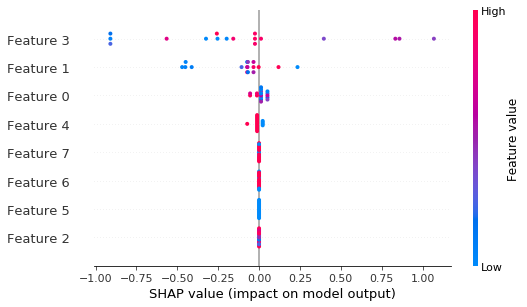

In [13]:
#This code produces a beeswarm plot showing the impact of the top 10 features on the model when its value is 0.
#creates the explainer object
explainer = shap.TreeExplainer(myFinalModel)
#produces values from the test set. 
shap_values = explainer.shap_values(X_test)
#creates the shap object for the plot
shap_object = explainer(X_test)
#produces the plot
shap.summary_plot(shap_values[0],X_test)


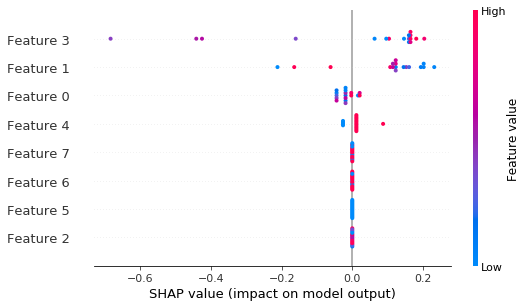

In [14]:
#This code produces a beeswarm plot showing the impact of the top 10 features on the model when its value is 1.
#creates the explainer object
explainer = shap.TreeExplainer(myFinalModel)
#produces values from the test set. 
shap_values = explainer.shap_values(X_test)
#creates the shap object for the plot
shap_object = explainer(X_test)
#produces the plot
shap.summary_plot(shap_values[1],X_test)

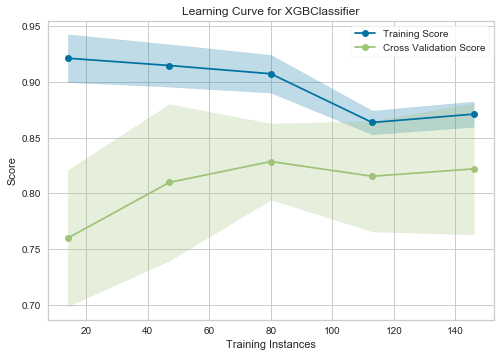

LearningCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000266AF42A848>,
              cv=10,
              estimator=XGBClassifier(average='micro', base_score=0.5,
                                      booster='gbtree', colsample_bylevel=1,
                                      colsample_bynode=1, colsample_bytree=1,
                                      enable_categorical=False,
                                      eval_metric='logloss', gamma=0, gpu_id=-1,
                                      importance_type=None,
                                      interaction_constraints='',
                                      learning_rate=0.30...
                                      n_estimators=10, n_jobs=16, num_class=8,
                                      num_parallel_tree=1,
                                      objective='multi:softmax',
                                      predictor='auto', random_state=1,
                                      reg_alpha=0, reg_lambd

In [24]:
#Uses the learning curve function from the yellowbrick library to identify if the model could benefit from more training samples. 
from yellowbrick.model_selection import learning_curve
#prints the learning curve plot. 
print(learning_curve(myFinalModel,x_frame, y_frame,cv=10,))

[14:06:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


>1, train: 0.920, test: 0.922
[14:06:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


>2, train: 0.920, test: 0.922
[14:06:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parame

>19, train: 0.920, test: 0.922
[14:07:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


>20, train: 0.920, test: 0.922


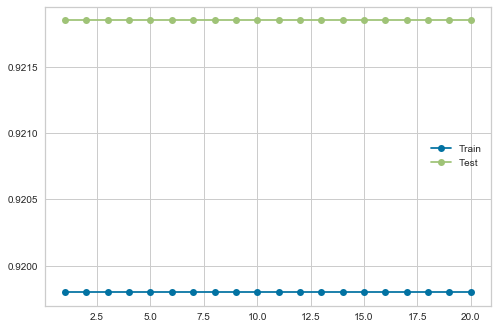

In [23]:
#import libraries 
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# create dataset with n_samples. 
X, y = make_classification(n_samples=100000, random_state=1)
# split into train test sets 80 20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# define lists to collect accuracy scores. 
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
#for loop that takes split above and plots train vs test to determine fit.
for i in values:
    myFinalModel.fit(X_train, y_train)
    # evaluate on the train dataset
    train_yhat = myFinalModel.predict(X_train)
    #determines accuracy score of training data set model.
    train_acc = accuracy_score(y_train, train_yhat)
    #appends train accuracy score to list. 
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = myFinalModel.predict(X_test)
    #determines accuracy score of test data set model 
    test_acc = accuracy_score(y_test, test_yhat)
    #appends the test accuracy score to list. 
    test_scores.append(test_acc)
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores 
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

Based on the plots above the model is underfitting and would benefit from more trainin data. 

No exploratory data analysis was performed as entries with missing data were removed, the data was already normalized and removing outliers would not be ideal as the normal varience in the population is uknown for all 62000 transcripts. 